In [1]:
import nilearn
import os
import re
from nilearn.input_data import NiftiMapsMasker, NiftiLabelsMasker
from nilearn import datasets, plotting
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numba import jit
import warnings
warnings.filterwarnings('ignore')

plt.style.use("~/.config/matplotlib/custom")

In [2]:

directory = "/home/ilkin/Documents/GitHub/datasci/fmri/difumo_atlases/1024/2mm/binarised_rois"
rois = []
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        rois.append(int(re.findall('_(.*?)\.', filename)[0]))
rois = np.array(sorted(rois))
rois[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [3]:
lsd_dict = {}
pcb_dict = {}
for i in range(1, 4):
    lsd_dict[i] = pd.read_csv(f'/home/ilkin/Documents/GitHub/datasci/fmri/difumo/LSD/rest{i}/S01_LSD_rest{i}_noscrub_all_parcellation_difumo_ts.1D', delimiter=' ', header=None)[rois]
    pcb_dict[i] = pd.read_csv(f'/home/ilkin/Documents/GitHub/datasci/fmri/difumo/PCB/rest{i}/S01_PCB_rest{i}_noscrub_all_parcellation_difumo_ts.1D', delimiter=' ', header=None)[rois]

lsd = pd.concat([lsd_dict[i] for i in range(1, 4)], ignore_index=True)
pcb = pd.concat([pcb_dict[i] for i in range(1, 4)], ignore_index=True)
n_parcs = lsd.shape[1]
print(rois[-10:])
pcb

[1010 1011 1013 1015 1016 1018 1019 1020 1022 1023]


,1,2,3,4,5,6,7,8,9,10,...,1010,1011,1013,1015,1016,1018,1019,1020,1022,1023
0,339.718140,209.341309,100.173340,193.752075,242.403931,187.633057,373.910400,253.362671,205.888733,246.181427,...,261.721466,216.387299,302.864349,354.808929,363.019775,301.987671,194.303864,0.624082,207.672302,225.940735
1,339.726379,209.295410,99.318481,193.882812,242.385132,187.602051,373.935547,252.888062,205.894104,245.137512,...,262.602509,216.379150,302.387115,354.804138,363.022003,301.944000,194.312958,0.615273,207.682281,225.928909
2,339.574585,209.383728,98.466797,194.024170,242.505371,187.386841,374.460083,250.048096,206.145508,245.421509,...,261.446869,216.756866,303.432648,354.334320,363.003784,302.126068,194.014175,0.611312,207.867233,225.878784
3,339.423462,209.459839,99.106812,194.692139,242.401855,187.004517,374.685181,251.564087,206.314758,245.477325,...,260.994476,217.063263,305.072083,354.002869,362.868042,302.288544,193.776398,0.629537,208.041519,225.888092
4,339.376709,209.680237,98.504028,195.166748,242.140869,186.583130,374.489136,251.390503,206.366394,245.569000,...,261.087708,217.198792,305.098419,353.943146,362.652710,302.180542,193.810760,0.613607,208.224396,225.887772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,339.529236,209.670471,98.478027,195.781616,241.719360,186.869751,373.775513,250.256226,206.765991,246.560638,...,261.700745,216.488297,304.628113,354.840912,362.635010,301.792938,195.496902,0.590509,207.487854,226.239624
647,339.626526,209.624268,93.679321,195.788330,242.180542,187.031128,374.322998,253.970581,207.403564,246.458740,...,262.856842,216.598389,305.416687,354.953156,362.530426,301.658203,195.328552,0.557379,207.366653,226.258087
648,339.756348,209.728882,96.296265,195.524292,242.529297,187.459839,374.353394,254.920654,207.904541,245.902435,...,262.074860,216.667557,305.685974,354.931061,362.483093,301.671295,195.021606,0.572295,207.433517,226.268250
649,339.872253,209.911072,95.090088,195.300659,242.592529,187.861938,373.971558,256.089722,208.112610,245.602844,...,262.211121,216.662109,303.484802,354.798218,362.537537,301.828156,194.710251,0.551206,207.628738,226.220795


<Axes: >

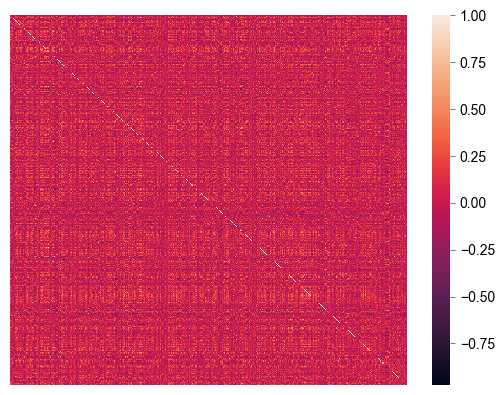

In [4]:
lsd_corr = np.corrcoef(lsd.to_numpy().T)
pcb_corr = np.corrcoef(pcb.to_numpy().T)
sns.heatmap(lsd_corr, xticklabels=[], yticklabels=[])

In [6]:
@jit
def ret_frus(mat):
    frus_mat = np.zeros((n_parcs, n_parcs, n_parcs))
    for i in range(n_parcs):
        for j in range(i+1, n_parcs):
            for k in range(j+1, n_parcs):
                y = mat[i,j]*mat[i,k]*mat[j,k]
                b = y < 0
                frus_mat[i, j] += b
                frus_mat[i, k] += b
                frus_mat[j, k] += b
        print(i)
    return frus_mat
lsd_frus = ret_frus(lsd_corr)
# pcb_frus = ret_frus(pcb_corr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [6]:
@jit
def ret_frus(mat):
    prod_mat = np.zeros((n_parcs, n_parcs, n_parcs))
    for i in range(n_parcs):
        for j in range(i+1, n_parcs):
            for k in range(j+1, n_parcs):
                prod = mat[i,j]*mat[i,k]*mat[j,k] < 0
                prod_mat[i, j, k] = prod
                prod_mat[i, k, j] = prod
                prod_mat[j, i, k] = prod
                prod_mat[j, k, i] = prod
                prod_mat[k, j, i] = prod
                prod_mat[k, i, j] = prod
    return prod_mat.sum(0)
lsd_frus = ret_frus(lsd_corr)
pcb_frus = ret_frus(pcb_corr)

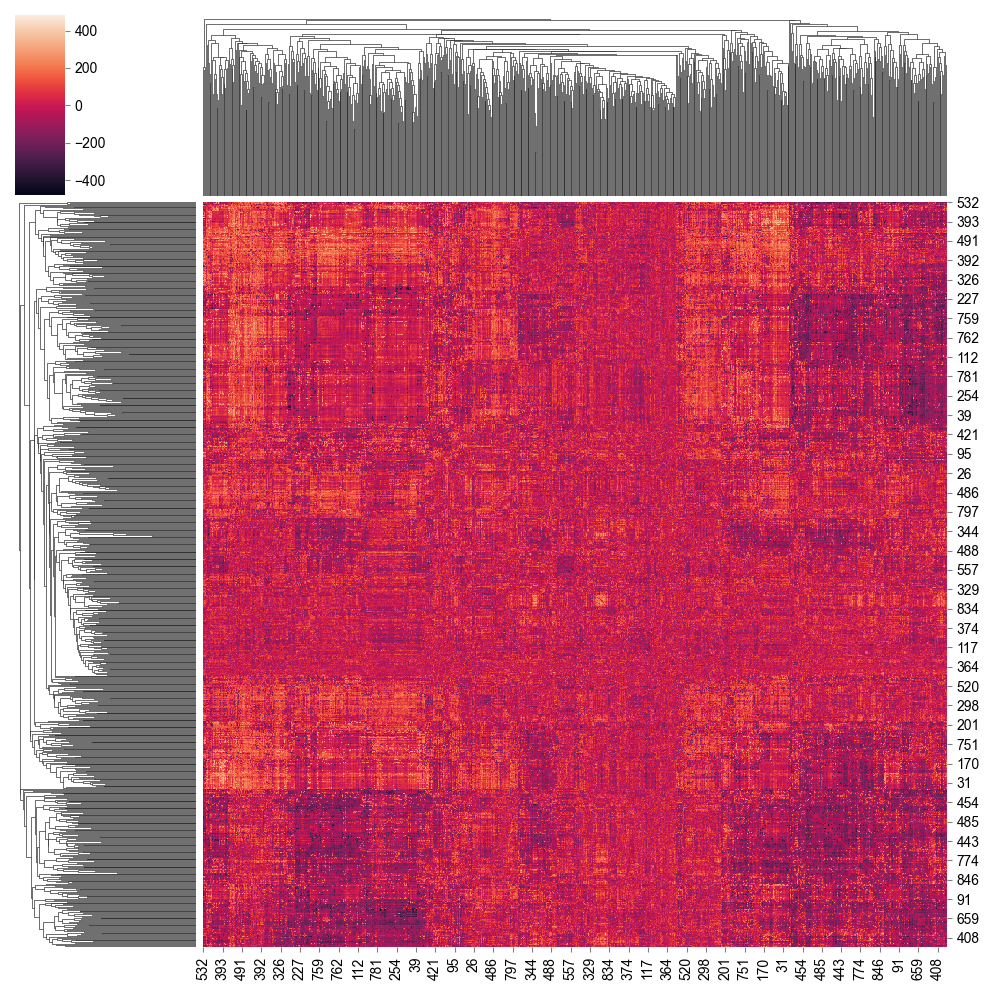

In [10]:
sns.clustermap(lsd_frus - pcb_frus)

<Axes: >

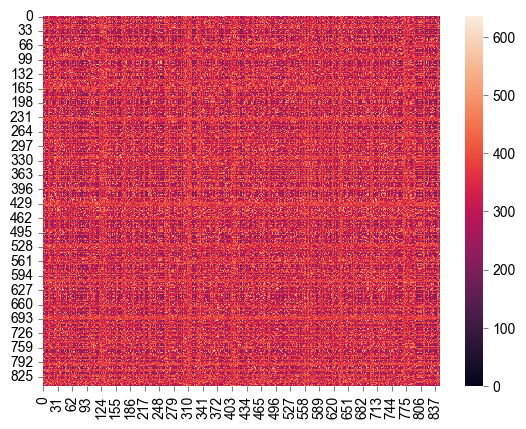

In [11]:
import scipy.cluster.hierarchy as sch

d = sch.distance.pdist(lsd_frus)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
sns.heatmap(lsd_frus[:, ind])